## SPATIAL TRANSCRIPTOMICS – IDENTIFICATION OF SVGs WITH SPATIALDE

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [ ]:
# use conda env from readme

2. Import necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import os
import NaiveDE
import SpatialDE
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import ipywidgets as w
w.IntSlider()
import csv

# cpu usage and time statistics
import psutil
import time
import platform

### Load the Datasets
Perform SpatialDE test on data in input files.

expression_csv : A CSV file with expression valies. Columns are genes,
and Rows are samples

coordinates_csv : A CSV file with sample coordinates. Each row is a sample,
the columns with coordinates must be named 'x' and 'y'. For other formats
(e.g. 1d or 3d queries), it is recommended to write a custom Python
script to do the analysis.

output_file : P-vaues and other relevant values for each gene
will be stored in this file, in CSV format.

In [2]:
# Edit these as needed
expression_csv = r"data_after_qc\SN048_A121573_Rep2\count.not_normalized.csv"
coordinate_csv = r"data_after_qc\SN048_A121573_Rep2\idx.not_normalized.csv"

# Base folder to save all output
base_dir = r"data_after_qc\SN048_A121573_Rep2\results_spatialDE"
# Create folder if it doesn't exist
os.makedirs(base_dir, exist_ok=True)
results_csv = os.path.join(base_dir, "results.csv")

# model_selection_csv = r"data_after_qc\SN048_A121573_Rep2\results_spatialDE\model_selection.csv"
# alfa_m = 0.05

### Get platform information

In [3]:
# ---- System info ----
cpu_model = platform.processor()
cpu_cores = psutil.cpu_count(logical=False)
cpu_threads = psutil.cpu_count(logical=True)

total_ram = psutil.virtual_memory().total / (1024**3)  # GB

print("CPU model:", cpu_model)
print("CPU cores:", cpu_cores)
print("CPU threads:", cpu_threads)
print("Total RAM: {:.2f} GB".format(total_ram))

# ---------------- SAVE TO CSV -----------------
csv_file = os.path.join(base_dir, "system_info.csv")

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CPU_model", "CPU_cores", "CPU_threads", "Total_RAM_GB"])
    writer.writerow([cpu_model, cpu_cores, cpu_threads, round(total_ram, 2)])

print(f"System info saved to {csv_file}")

CPU model: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores: 4
CPU threads: 8
Total RAM: 7.79 GB
System info saved to data_after_qc\SN048_A121573_Rep2\results_spatialDE\system_info.csv


### SpatialDE analysis

In [105]:
df = pd.read_csv(expression_csv, index_col=0)

df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

sample_info = pd.read_csv(coordinate_csv, index_col=0)

sample_info['total_counts'] = df.sum(1)
sample_info = sample_info.query('total_counts > 5')  # Remove empty features

df = df.loc[sample_info.index]   
X = sample_info[['x', 'y']]


# Convert data to log-scale, and account for depth
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T


In [109]:
print("SpatialDE analysis")

process = psutil.Process(os.getpid())
process.cpu_percent(interval=None)   # reset counters

start_cpu = time.process_time()
start_wall = time.time()

# -------- code to measure -----------
# Perform Spatial DE test with default settings
results = SpatialDE.run(X, res)
# ------------------------------------

end_cpu = time.process_time()
end_wall = time.time()

cpu_time = end_cpu - start_cpu
wall_time = end_wall - start_wall
cpu_usage = process.cpu_percent(interval=None)
ram_usage = process.memory_info().rss / (1024**2)  # MB

print("CPU time: {:.6f} seconds".format(cpu_time))
print("Wall time: {:.6f} seconds".format(wall_time))
print("CPU usage (%):", cpu_usage)
print("RAM used by process: {:.2f} MB".format(ram_usage))

# ---------------- SAVE TO CSV -----------------
with open(os.path.join(base_dir,  "requirements.csv"), "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["somde analysis", cpu_time, wall_time, cpu_usage, ram_usage])


SpatialDE analysis


c:\Users\irato\miniconda3\envs\spatialde_py39\lib\site-packages\SpatialDE\base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
c:\Users\irato\miniconda3\envs\spatialde_py39\lib\site-packages\SpatialDE\base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19958 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# Save results and annotation in files for interactive plotting and interpretation
results.to_csv(results_csv)

Optionally, we can generate a model-selection file for genes that have an adjusted p-value greater than alpha.


In [ ]:
# de_results = results[(results.qval < alfa_m)].copy()
# ms_results = SpatialDE.model_search(X, res, de_results)

# ms_results.to_csv(model_selection_csv)

# Visualisation

If the analysis already done, you can download the results for visualisation.

In [44]:
res_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\res.csv"
results_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\results.csv"
sample_info_p = r"C:\MUNI\IV114_ST\data_after_qc\SN048_A121573_Rep1\sample_info.csv"

res = pd.read_csv(res_p, index_col=0)
results = pd.read_csv(results_p, index_col=0)
sample_info = pd.read_csv(sample_info_p, index_col=0)

In [51]:
# Edit these as needed
alfa_v = 0.05
fsv_thr = 0.8
qval_thr = 0.000001

Volkano plot - the relation between significance and effect size. Efect size is the fraction of variance explained by spatial variation.

FileNotFoundError: [Errno 2] No such file or directory: 'data_after_qc\\SN048_A121573_Rep2\\results_spatialDE\\volcano_plot.png'

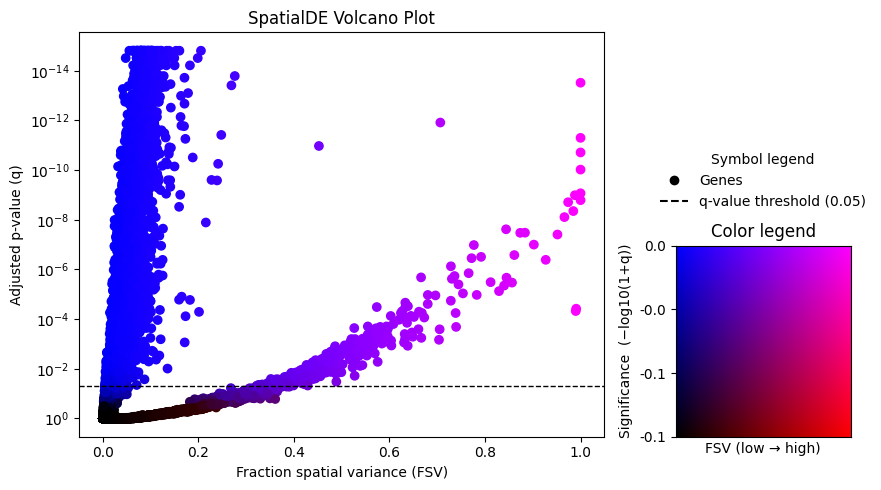

In [ ]:
# Use pandas Series directly
x = results['FSV']
y = results['qval']

# ---- BLUE CHANNEL: significance from -log10(1+q) ----
sig = -np.log10(1 + y)

# Percentile clipping to enhance dynamic range
low, high = np.percentile(sig, [50, 100])
sig_clipped = np.clip(sig, low, high)
sig_norm = (sig_clipped - low) / (high - low)

# ---- BUILD RGB COLOR ARRAY ----
# Red channel = FSV, Blue channel = normalized significance
colors = np.zeros((len(x), 3))
colors[:, 0] = x          # assumes FSV roughly in [0,1]; otherwise normalize
colors[:, 2] = sig_norm

# ---- FIGURE WITH 2D LEGEND ----
fig = plt.figure(figsize=(9, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[0.6, 2])

# ---------------------- MAIN VOLCANO PLOT ----------------------
ax = fig.add_subplot(gs[:, 0])
ax.set_yscale('log')

ax.scatter(x, y, c=colors)

ax.axhline(alfa_v, c='black', lw=1, ls='--')
ax.invert_yaxis()

ax.set_xlabel('Fraction spatial variance (FSV)')
ax.set_ylabel('Adjusted p-value (q)')
ax.set_title('SpatialDE Volcano Plot')

# ---------------------- 2D COLOR LEGEND (log-significance axis) ----------------------
legend_ax = fig.add_subplot(gs[1, 1])

pix = 150
fsv_grad = np.linspace(0, 1, pix)         # horizontal gradient (FSV)
sig_axis = np.linspace(low, high, pix)    # vertical axis in -log10(1+q) units
F, S = np.meshgrid(fsv_grad, sig_axis)

legend_colors = np.zeros((pix, pix, 3))
legend_colors[..., 0] = F                             # red = FSV
legend_colors[..., 2] = (S - low) / (high - low)      # map log sig to 0–1 like sig_norm

legend_ax.imshow(
    legend_colors,
    origin='lower',
    aspect='auto',
    extent=[0, 1, low, high]   # y-axis in -log10(1+q)
)

legend_ax.set_xlabel('FSV (low → high)')
legend_ax.set_ylabel('−log10(1+q) (low → high)')
legend_ax.set_title('Color legend')

legend_ax.set_xticks([])

# nice ticks on log-significance axis
yticks = np.linspace(low, high, 4)
legend_ax.set_yticks(yticks)
legend_ax.set_yticklabels([f"{v:.1f}" for v in yticks])

# ---------------------- SYMBOL LEGEND ABOVE COLOR LEGEND ----------------------
scatter_proxy = mlines.Line2D(
    [], [], color='black', marker='o', linestyle='None',
    markersize=6, label='Genes'
)
threshold_proxy = mlines.Line2D(
    [], [], color='black', linestyle='--',
    label=f'q-value threshold ({alfa_v})'
)

legend_ax.legend(
    handles=[scatter_proxy, threshold_proxy],
    loc='upper center',
    bbox_to_anchor=(0.50, 1.55),     # above the color legend
    title='Symbol legend',
    frameon=False
)

plt.tight_layout()

# Save volcano plot
volcano_file = os.path.join(base_dir, "volcano_plot.png")
plt.savefig(volcano_file, dpi=300)
plt.show()


Then there are choosen the best genes.

Number of genes with q ≤ 1e-06 and FSV ≥ 0.8: 21
Number of genes with q ≤ 0.05: 6999


FileNotFoundError: [Errno 2] No such file or directory: 'data_after_qc\\SN048_A121573_Rep2\\results_spatialDE\\volcano_plot_best_genes.png'

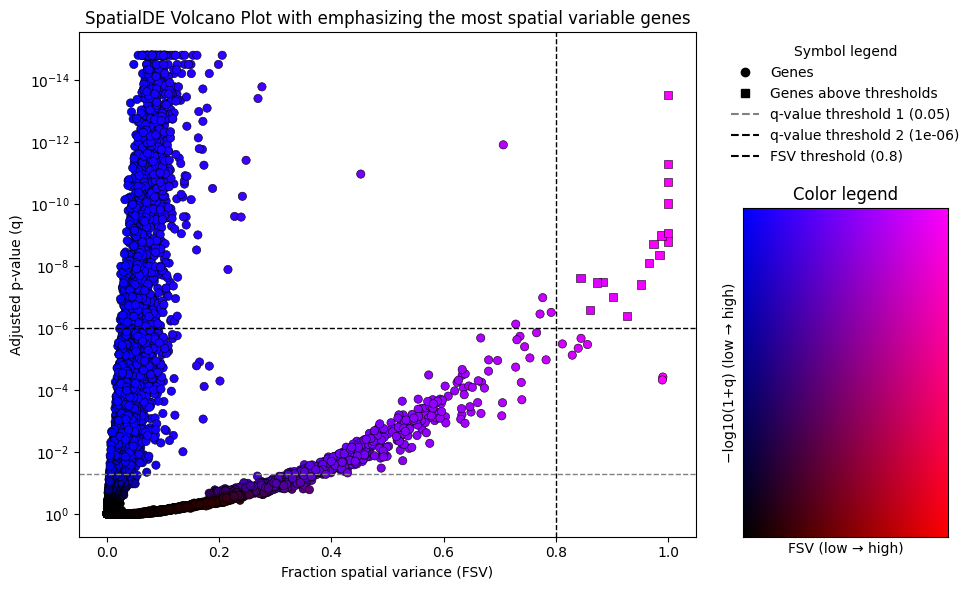

In [52]:
# Mask for upper-right quadrant: high FSV AND low q-value
mask_top_right = (x >= fsv_thr) & (y <= qval_thr)
mask_top_right_np = mask_top_right.to_numpy()

# Inverse mask: all other genes
mask_rest = ~mask_top_right
mask_rest_np = ~mask_top_right_np

n_top_right = int(mask_top_right.sum())
print(f"Number of genes with q ≤ {qval_thr} and FSV ≥ {fsv_thr}: {n_top_right}")

mask_q1 = (y <= alfa_v)
n_q1 = int(mask_q1.sum())
print(f"Number of genes with q ≤ {alfa_v}: {n_q1}")

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[0.6, 2])

# ===================== MAIN VOLCANO PLOT (LEFT) =====================
ax = fig.add_subplot(gs[:, 0])
ax.set_yscale('log')

# 1) All other genes as circles
ax.scatter(
    x[mask_rest],
    y[mask_rest],
    c=colors[mask_rest_np],
    marker='o',
    edgecolor='black',
    linewidth=0.4
)

# 2) Upper-right quadrant genes as squares (no circles underneath)
ax.scatter(
    x[mask_top_right],
    y[mask_top_right],
    c=colors[mask_top_right_np],
    marker='s',
    edgecolor='black',
    linewidth=0.4
)

# Y-axis thresholds (horizontal lines)
ax.axhline(alfa_v,   c='grey',  lw=1, ls='--')  # q-value threshold 1  
ax.axhline(qval_thr, c='black', lw=1, ls='--')  # q-value threshold 2

# X-axis threshold (vertical line)
ax.axvline(fsv_thr, c='black', lw=1, ls='--')   # FSV threshold

# Volcano convention: smallest q-values appear at the top
ax.invert_yaxis()

ax.set_xlabel('Fraction spatial variance (FSV)')
ax.set_ylabel('Adjusted p-value (q)')
ax.set_title('SpatialDE Volcano Plot with emphasizing the most spatial variable genes')

# ===================== 2D BIVARIATE COLOR LEGEND (BOTTOM RIGHT) =====================
legend_ax_bottom = fig.add_subplot(gs[1, 1])

pix = 150
fsv_grad = np.linspace(0, 1, pix)     # horizontal gradient (FSV)
# vertical axis in *actual* log significance units: from low to high
sig_axis = np.linspace(low, high, pix)  # low/high = percentiles of -log10(1+q)
F, S = np.meshgrid(fsv_grad, sig_axis)

legend_colors = np.zeros((pix, pix, 3))
legend_colors[..., 0] = F                         # red = FSV
legend_colors[..., 2] = (S - low) / (high - low)  # map log sig to 0–1 like sig_norm

legend_ax_bottom.imshow(
    legend_colors,
    origin='lower',
    aspect='auto',
    extent=[0, 1, low, high]   # y-axis in log significance (-log10(1+q))
)

legend_ax_bottom.set_xlabel('FSV (low → high)')
legend_ax_bottom.set_ylabel('−log10(1+q) (low → high)')
legend_ax_bottom.set_title('Color legend')

legend_ax_bottom.set_xticks([])
legend_ax_bottom.set_yticks([])

# ===================== SYMBOL LEGEND (TOP RIGHT, OWN AXES) =====================
legend_ax_top = fig.add_subplot(gs[0, 1])
legend_ax_top.axis('off')

scatter_proxy = mlines.Line2D(
    [], [], color='black', marker='o',
    linestyle='None', markersize=6,
    label='Genes'
)
square_proxy = mlines.Line2D(
    [], [], color='black', marker='s',
    linestyle='None', markersize=6,
    label='Genes above thresholds'
)
q1_proxy = mlines.Line2D(      
    [], [], color='grey', linestyle='--',
    label=f'q-value threshold 1 ({alfa_v})'
)
q2_proxy = mlines.Line2D(
    [], [], color='black', linestyle='--',
    label=f'q-value threshold 2 ({qval_thr})'
)
x_proxy = mlines.Line2D(
    [], [], color='black', linestyle='--',
    label=f'FSV threshold ({fsv_thr})'
)

legend_ax_top.legend(
    handles=[scatter_proxy, square_proxy,q1_proxy, q2_proxy, x_proxy],   
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    frameon=False,
    title='Symbol legend'
)

# ------------------------------------------------------------------
plt.tight_layout()

# Save volcano plot
volcano_file = os.path.join(base_dir, "volcano_plot_best_genes.png")
plt.savefig(volcano_file, dpi=300)
plt.show()

Graph of the tissue with the color correspond to expression level of top the genes, that was marked as the best priviously.

In [ ]:
# Get gene names that pass the strict threshold
strict_genes = results.loc[mask_top_right, 'g']

# Create maps for gene → l and gene → qval (using strict genes)
l_map = results.set_index('g')['l'].to_dict()    
qval_map = results.set_index('g')['qval'].to_dict()

# Dropdown will contain only genes passing strict threshold
strict_gene_list = list(strict_genes)

# Function to plot a selected gene
def plot_gene(gene):
    l_value = l_map[gene]
    qval_value = qval_map[gene]

    title = f"{gene} | l = {l_value:.3f} | qval = {qval_value:.2e}"

    # square-ish figure, no extra empty space
    fig, ax = plt.subplots(figsize=(5, 5))

    sc = ax.scatter(
        sample_info['x'],
        sample_info['y'],
        c=res[gene],
        cmap='viridis',
        s=12,             
        edgecolors='none'
    )

    ax.set_title(title, fontsize=12)
    ax.set_aspect('equal')

    # remove ticks (cleaner map)
    ax.set_xticks([])
    ax.set_yticks([])

    # --- COLORBAR ---
    # fraction = how thick; pad = distance from plot
    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.01)
    cbar.set_label('Expression', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # tight layout to remove white space
    fig.tight_layout()

    # Save
    file_path = os.path.join(base_dir, f"{gene}.png")
    fig.savefig(file_path, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


# ---- Interactive dropdown ----
w.interact(
    plot_gene,
    gene=w.Dropdown(options=strict_gene_list, description="SVG:")
)

Index identical: True


interactive(children=(Dropdown(description='SVG:', options=('RAB42', 'DKK2', 'COL25A1', 'PCDHGA2', 'LY86-AS1',…

<function __main__.plot_gene(gene)>